In [ ]:
# Example-5-MC-GPA-IRS-CVA
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Stéphane Crépey and  Matthew Dixon, Gaussian Process Regression for Derivative Portfolio Modeling and Application to CVA Computations, to appear in J. Computational Finance, 2020.
# c.f. https://arxiv.org/abs/1901.11081


# Overview
This example demonstrates the application of GPs to CVA modeling on a counterparty portfolio of IRS contracts with 11 currencies and 10 FX processes. The notebook simulates the GP MtM cube of the portfolio, compare the Expected Positive Exposure when using a GP derivative pricing model versus a BS pricing model and calculate the CVA_0.

## Data preparation
In the data, the interest rates appear first and then the FX processes, so that if 0<=j<=num_rates-1, then the j-th process is the j-th interest rate and, ignoring j=0, the (num_rates+j-1)-th process is the FX process whose foreign currency is the j-th one.

For example, in the case of 3 currencies (and therefore 2 FX rates) we would have a spacial arrangement like this:

|rate_0|rate_1|rate_2|FX_0|FX_1|


In the rates cube, [i,j,k] refers to the i-th coarse time step, j-th interest rate process if $j\leq #ratesj \leq \#ratesj\leq#rates$ or (j-num_rates)-th FX process otherwise, and k-th Monte-Carlo scenario.

## Data Download

Please download the following five npz files from google drive:

- https://drive.google.com/file/d/1-0fMzY8sgoAvkT_BJN7bLUdRY_3Ozjoz/view?usp=drive_web

- https://drive.google.com/file/d/1-EX-V08JVhB7ZsuzFqwXvK7JsQErWtWu/view?usp=drive_web

- https://drive.google.com/file/d/1-AniapWnwDeU5IlsR1IrLdwWTKFnlqxr/view?usp=drive_web

- https://drive.google.com/file/d/1-73kFXfe5OIrPDXmRqNVxOieUXnio8jt/view?usp=drive_web
- https://drive.google.com/file/d/1-6xGJJx4FQJ6eOvsnSEH3SordmvVlrgD/view?usp=drive_web

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
mtm_irs=np.load('../IRS/mtm_irs.npz')

In [5]:
rates_and_fx=np.load('../IRS/rates_and_fx.npz')

In [6]:
irs_params=np.load('../IRS/irs_params.npz')

In [7]:
rate_params=np.load('../IRS/rate_params.npz')

# Aggregate underlying data together

The aggregation of the data is as follows:
- Select counterparty portfolio (1 of 5)
- Select a IRS contract i
- Select times t={t_j}
- Get M simulated prices from mtm_irs[t, i, M]

- Get currency from irs_params['arr_0'][i]
- Get foreign rate and FX if currency neq 0, else get domestic rate

In [8]:
cpty_idx=0
port_idx=[]
for i in range(len(irs_params['arr_0'])):
 if (irs_params['arr_0'][i][5]==cpty_idx):
    port_idx.append(i)

In [9]:
port_idx=np.array(port_idx)
T = np.shape(mtm_irs['arr_0'])[0]

In [10]:
np.shape(mtm_irs['arr_0'])

(101, 50, 32768)

### Reset dates

In [11]:
reset_idx=(np.arange(101)-1)//5*5

In [12]:
M= 2000

In [13]:
# construct IRS mapping to rates
irs_map ={}
for i in port_idx:
    ccy=irs_params['arr_0'][i][6]
    if (ccy==0):
       irs_map[i]=[0] #domestic rate
    else:
       irs_map[i]=[ccy, 10+ccy] # foreign rate + FX rate

In [14]:
mtm = []
rates_fx = []
prev_rates_fx = []
for t in arange(5,T,10):     
 mtm.append(mtm_irs['arr_0'][t,port_idx,:2*M])
 prev_rates_fx.append(rates_and_fx['arr_0'][t-5,:,:2*M].T) # previous reset date
 rates_fx.append(rates_and_fx['arr_0'][t,:,:2*M].T)

nt = len(arange(1,T,10))

In [15]:
# option method for sampling the input space
def stratified_sampling(ar, M):
    quantiles = [0,0.25,0.5,0.75, 1]
    num_buckets = len(quantiles)-1
    q= np.quantile(ar, quantiles, axis=0)
    
    idx=np.array([], dtype=int)
    sum_ =0
    dim = np.shape(ar)[1]
    #print(dim)
    num_samples = int(M/(num_buckets**dim))
    #print(num_samples)
    if (dim==2): # domestic
        for i in range(num_buckets):
          for j in range(num_buckets):
           idx_=np.where((ar[:,0] >= q[i,0]) & (ar[:,0] <= q[i+1,0]) & (ar[:,1] >= q[j,1]) & (ar[:,1] <= q[j+1,1]))
           if (len(idx_[0])> num_samples):
             idx__=idx_[0][:num_samples]

           else: # oversample
             idx__=np.random.choice(idx_[0], num_samples) # sample with replacement 

           sum_+=len(idx__) 
           #print(i,j,sum_)
           idx= np.append(idx,idx__)
    else: 
         counter =0
         for i in range(num_buckets):
          for j in range(num_buckets):
            for k in range(num_buckets):
               idx_=np.where((ar[:,0] >= q[i,0]) & (ar[:,0] <= q[i+1,0]) & (ar[:,1] >= q[j,1]) & (ar[:,1] <= q[j+1,1]) & (ar[:,2] >= q[k,2]) & (ar[:,2] <= q[k+1,2]))
               if (len(idx_[0])> num_samples):
                 idx__=idx_[0][:num_samples]
                 idx= np.append(idx,idx__)
                 sum_+=len(idx__)
               elif(len(idx_[0])>0): # oversample
                 idx__=np.random.choice(idx_[0], num_samples) # sample with replacement 
                 
                 #print(i,j,sum_)
                 idx= np.append(idx,idx__)
                 sum_+=len(idx__)
               else:
                 counter+=1 
                 print(i,j,k,0, counter)
                  
    
    # ensure that minimums and maximums are in the training set
    idx_min= np.argmin(ar, axis=0)
    idx_max= np.argmax(ar, axis=0)
    
    idx[0:dim]=idx_min
    idx[dim:(2*dim)]=idx_max
    print(sum_)
    return(idx)  

## GP kernel specification

In [16]:
sk_kernel_matern = Matern(length_scale=1.0, nu=0.5, length_scale_bounds=(0.01,10000)) #(1e-05, 1000.0))  #100000.0
sk_kernel_rbf = RBF(length_scale=1.0, length_scale_bounds=(0.01,10000)) #(1e-05, 1000.0))  #100000.0

In [17]:
portfolio ={}
for idx in port_idx:
    portfolio[idx]={'GPs':np.array([0]*nt, dtype=object), 'weight':1, 
                    'min':np.array([0]*nt, dtype=object), 
                    'max':np.array([0]*nt, dtype=object), 
                    'min_sc_x':np.array([0]*nt, dtype=object),
                    'max_sc_x':np.array([0]*nt, dtype=object),
                    'min_sc_y':np.array([0]*nt, dtype=object), 
                    'max_sc_y':np.array([0]*nt, dtype=object)
                }

gps =[]
for i in range(nt): # len(mtm)
    for j in range(20): #len(port_idx)):
      n_rates=len(irs_map[port_idx[j]])
      if i>0:
          rates_ = np.zeros([2*M,n_rates+1])  
          rates_[:,0]=prev_rates_fx[i][:,irs_map[port_idx[j]][0]]
          rates_[:,1:]=rates_fx[i][:,irs_map[port_idx[j]]] 
      else:
          rates_ = np.zeros([2*M,n_rates])  
          rates_=rates_fx[i][:,irs_map[port_idx[j]]] 
      idx=range(int(M/2)) # stratified_sampling(rates_,M)
      print(len(idx))  
      gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel_matern, n_restarts_optimizer=20)
      # rescale x and y to the unit interval
      rates_sc_=(rates_ - np.min(rates_, axis=0))/(np.max(rates_, axis=0) -np.min(rates_, axis=0) + 1e-16)
      irs_prices=mtm[i][j,:]
        
      if ((np.max(irs_prices) -np.min(irs_prices))!=0):  
          irs_prices_sc_=(irs_prices - np.min(irs_prices))/(np.max(irs_prices) -np.min(irs_prices))
      else:
          irs_prices_sc_=irs_prices - np.min(irs_prices)
      #portfolio[port_idx[j]]['GPs'][i]=gp
      portfolio[port_idx[j]]['GPs'][i]=gp.fit(rates_sc_[idx,:],irs_prices_sc_[idx]) 
      portfolio[port_idx[j]]['min'][i]=np.min(rates_[idx,:], axis=0)
      portfolio[port_idx[j]]['max'][i]=np.max(rates_[idx,:], axis=0)
      portfolio[port_idx[j]]['min_sc_x'][i]=np.min(rates_, axis=0)
      portfolio[port_idx[j]]['max_sc_x'][i]=np.max(rates_, axis=0)
      portfolio[port_idx[j]]['min_sc_y'][i]=np.min(irs_prices)
      portfolio[port_idx[j]]['max_sc_y'][i]=np.max(irs_prices)
        
      print(i,j)

1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00070292]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00070292]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.001904

0 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00067002]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 92, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0660011]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00172575]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gp

0 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.77354162]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 44, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.52652234]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.397668

0 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00018881]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00182142]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00686176]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gp

0 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00697322]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.03923705]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0163485

0 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00374552]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00175592]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00374552]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gp

0 5
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0063325]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.04671999]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00710928

0 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00017965]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.01402303]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00388539]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.

0 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00036779]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00033841]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.13889766]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gp

0 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00256619]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00063531]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 105, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00063

0 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.53690675]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


0 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01539106]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00082807]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0014869

0 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-33.90419808]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.0477902]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([22.203138

0 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00027958]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00013609]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.006812

0 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.20085051]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.08533236]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-14.54094668]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


0 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00090797]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00506976]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0510355

0 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00366862]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00028368]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00578175]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gp

0 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0923355]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00154169]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0015416

0 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01271602]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.001697]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03758782]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 130, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr

0 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.04337033]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00077067]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.001503

0 19
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00025265]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


1 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00087172]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 5
1000
1 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00073193]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


1 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00100922]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00075584]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.000617

1 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00044118]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00099871]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


1 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00028214]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


1 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


1 19
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00059985]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


2 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 5
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00045241]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


2 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


2 19
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00090848]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


3 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 5
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00017943]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


3 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00104523]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


3 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0006824]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


3 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


3 19
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00075663]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00030125]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


4 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00127181]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


4 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 5
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


4 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00072884]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


4 19
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0003771]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


5 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 5
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00017662]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


5 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00019141]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


5 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00107494]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


5 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5 19
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.000874]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


6 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 5
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00115387]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


6 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


6 19
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 5
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00241145]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


7 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


7 19
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 5
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


8 19
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 0
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 1
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 2
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 3
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 4
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 5
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 6
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 7
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 8
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 9
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 10
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 11
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 12
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 13
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 14
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 15
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 16
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 17
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 18
1000


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1377: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


9 19


In [1]:
# CVA simulation using the credit default model described in the above reference.
def CVA_simulation(sim_params, model_params, def_model):
    
    M        = sim_params['M']        # number of paths
    nt       = sim_params['nt']       # number of exposure dates 
    r        = model_params['r']
    T        = model_params['T'] 
    t0       = model_params['t0'] 
    haz_rate = model_params['lambda']
    n_instruments = model_params['size']
    
    pi = {}
    pi['tilde'] = np.array([0.0]*nt*M, dtype='float32').reshape(nt, M)     # GP portfolio value
    pi['exact'] = np.array([0.0]*nt*M, dtype='float32').reshape(nt, M)     # BS portfolio value
    pi['tilde_var'] = np.array([0.0]*nt*M, dtype='float32').reshape(nt, M) # GP portfolio variance
    dPD = np.array([0.0]*nt*M, dtype='float32').reshape(nt, M)             # default probabilities
    dt = T/nt 
    
    for i in range(nt): # len(mtm) 
      
        pred_= 0
        var_ = 0
        obs_ = 0 

        for j in range(n_instruments): # loop over instruments
            idx=np.random.choice(range(2*M),M)
            irs_prices=mtm[i][j,idx] # test samples
            rates=rates_fx[i][:,irs_map[port_idx[j]]]  # test samples
            prev_rates=prev_rates_fx[i][:,irs_map[port_idx[j]][0]]  # test samples
               
            n_rates=np.shape(rates)[1]
            
            key = port_idx[j]
            # avoid simulated rates/FX breaching boundaries of training set
            
            if i>0:
              dim = n_rates+1
              test_rates = np.zeros([M,dim])  
              test_rates[:,0]=prev_rates[idx]
              test_rates[:,1:]=rates[idx,:] 
            else:
              dim = n_rates  
              test_rates= np.zeros([M,dim])  
              test_rates=rates[idx,:] 
              # rescale x and y to the unit interval
            
            for k in range(dim):
                idx_min=np.where(test_rates[:,k]<portfolio[key]['min'][i][k])
                idx_max=np.where(test_rates[:,k]>portfolio[key]['max'][i][k])
                if len(idx_min[0])>0:
                    #print("min",idx_min)
                    test_rates[idx_min,k]=portfolio[key]['min'][i][k]
                if len(idx_max[0])>0:
                    #print("max", idx_max)
                    test_rates[idx_max,k]=portfolio[key]['max'][i][k]
            
            min_=portfolio[port_idx[j]]['min_sc_x'][i]
            max_=portfolio[port_idx[j]]['max_sc_x'][i]
            
            test_rates_sc=(test_rates - min_)/(max_-min_)
            
            pred_sc, std = portfolio[key]['GPs'][i].predict(test_rates_sc,return_std=True) 
            #print(j, np.mean(pred), np.mean(irs_prices))
            min_y_=portfolio[port_idx[j]]['min_sc_y'][i]
            max_y_=portfolio[port_idx[j]]['max_sc_y'][i]
            
            pred= min_y_ + pred_sc*(max_y_-min_y_)
            std*=(max_y_-min_y_)
            pred_ += portfolio[key]['weight']*pred
            var_ += (portfolio[key]['weight']*std)**2 
            obs_ += portfolio[key]['weight']*irs_prices

        pi['tilde'][i,:] = pred_
        pi['exact'][i,:] = obs_
        pi['tilde_var'][i,:] = var_ 


        # compute default probabilities  
        dPD[i,:]= haz_rate *np.exp(-haz_rate*dt)#gamma[i-1,m]*exp_factor

    CVA ={}
    CVA['tilde'] = 0
    CVA['exact'] = 0
    CVA['exact_up'] = 0
    CVA['exact_down'] = 0
    CVA['tilde_up'] = 0
    CVA['tilde_down'] = 0
    
      
    for i in range(nt):  # timesteps
        time = i*dt
        mu_tilde = np.mean(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt
        CVA['tilde'] += mu_tilde
        std_tilde_err = np.std(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt/sqrt(M)
        
        CVA['tilde_up'] += mu_tilde + 2*std_tilde_err
        CVA['tilde_down'] += mu_tilde - 2*std_tilde_err
        mu_exact = np.mean(dPD[i,:]*pi['exact'][i,:])*np.exp(-r*(time-t0))*dt
        CVA['exact'] += mu_exact
        std_exact_err = np.std(dPD[i,:]*pi['exact'][i,:])*np.exp(-r*(time-t0))*dt/sqrt(M)
        CVA['exact_up'] += mu_exact + 2*std_exact_err
        CVA['exact_down'] += mu_exact - 2*std_exact_err
        
        
    CVA['tilde'] *= (1-def_model['recovery'])
    CVA['tilde_up'] *= (1-def_model['recovery'])
    CVA['tilde_down'] *= (1-def_model['recovery'])
    CVA['exact'] *= (1-def_model['recovery'])
    CVA['exact_up'] *= (1-def_model['recovery'])
    CVA['exact_down'] *= (1-def_model['recovery'])
     
        
    return(CVA, pi)

In [27]:
def_model ={}
def_model['recovery'] = 0.4 # recovery rate

sim_params ={}
sim_params['M']   = 1000   # Number of simulations  
sim_params['nt']  = 10     # Number of exposure dates
    
model_params= {}   
model_params['r'] = 0.02
model_params['T'] = 10.0 # Longest dated cash flow maturity in the portfolio 
model_params['t0'] = 0
model_params['lambda']=0.05 # constant hazard rate
model_params['size']=20 # number of instruments in portfolio


CVA_0, pi_0= CVA_simulation(sim_params, model_params, def_model)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/g

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/g

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/g

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/g

In [30]:
100*(CVA_0['exact']-CVA_0['tilde'])/CVA_0['exact'] # % error in CVA_0

0.24597032331362795

Compare the exact CVA, i.e. using BS prices, with the GP portfolio and provide the GP error bounds 

In [31]:
CVA_0

{'tilde': 3349.5871693198574,
 'exact': 3357.846475151162,
 'exact_up': 3535.9784394574003,
 'exact_down': 3179.714510844924,
 'tilde_up': 3522.0718258715874,
 'tilde_down': 3177.102512768127}

In [24]:
epe_gp=np.mean(pi_0['tilde'], axis=1)
epe_obs=np.mean(pi_0['exact'], axis=1)
epe_var=np.mean(pi_0['tilde_var'], axis=1)

Error plot in expected positive exposure

Text(0,0.5,'EPE (Euro)')

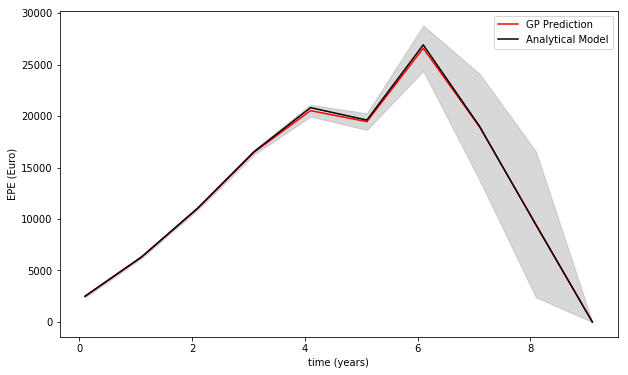

In [25]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(0.1+np.arange(10), epe_gp, color = 'red', label = 'GP Prediction')
plt.plot(0.1+np.arange(10), epe_obs, color = 'black', label = 'Analytical Model')
plt.fill_between(0.1+np.arange(10), (epe_gp-2.0*np.sqrt(epe_var)), (epe_gp+2.0*np.sqrt(epe_var)), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('time (years)')
plt.ylabel('EPE (Euro)')